In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

In [91]:
data = pd.read_csv('oasis_longitudinal.csv')

The dataset (https://www.kaggle.com/code/pranavplatti/detecting-early-alzheimer-s) сcomes from a study conducted on 150 patients some of which were diagnozed with dementia either at the beginning of the study or later in the study. The dataset includes various parameters of MRI images taken from the patients. Each of the patients was scanned at least once. The goal is to develop models that would be able to identify patients with dementia and pick the best performing model.

In [92]:
data.head()

Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76    12   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  2.0  27.0  0.0  1987  0.696  0.883  
1  2.0  30.0  0.0  2004  0.681  0.876  
2  NaN  23.0  0.5  1678  0.736  1.046  
3  NaN  28.0  0.5  1738  0.713  1.010  
4  NaN  22.0  0.5  1698  0.701  1.034

Exploratory analysis and preprocessing of the data

<Axes: xlabel='Group'>

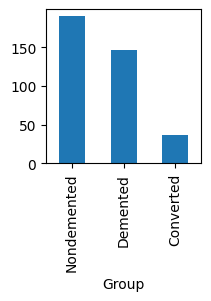

In [93]:
data.Group.value_counts().plot.bar(figsize=(2, 2))

In [94]:
data.Group = data.Group.apply(lambda x: 1 if x=='Nondemented' else 0)

Patients from the "converted" category eventually become demented, so they will be merged onto one group with patients from the "demented" category (group "0") for binary classification

Group
1    190
0    183
Name: count, dtype: int64

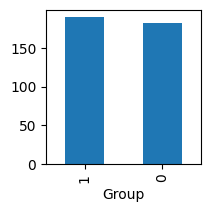

In [95]:
data.Group.value_counts().plot.bar(figsize=(2, 2))
data['Group'].value_counts()

In [96]:
to_drop = ['Subject ID', 'MRI ID']

In [97]:
data = data.drop(to_drop, axis = 1)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     373 non-null    int64  
 1   Visit     373 non-null    int64  
 2   MR Delay  373 non-null    int64  
 3   M/F       373 non-null    object 
 4   Hand      373 non-null    object 
 5   Age       373 non-null    int64  
 6   EDUC      373 non-null    int64  
 7   SES       354 non-null    float64
 8   MMSE      371 non-null    float64
 9   CDR       373 non-null    float64
 10  eTIV      373 non-null    int64  
 11  nWBV      373 non-null    float64
 12  ASF       373 non-null    float64
dtypes: float64(5), int64(6), object(2)
memory usage: 38.0+ KB


In [99]:
data.SES.unique()

array([ 2., nan,  3.,  4.,  1.,  5.])

In [100]:
data.MMSE.unique()

array([27., 30., 23., 28., 22., 29., 24., 21., 16., 25., 26., 15., 20.,
       19.,  7.,  4., 17., 18., nan])

In [101]:
data.SES = data.SES.transform(lambda x: x.fillna(x.median())).round(0)

In [102]:
data.MMSE = data.MMSE.transform(lambda x: x.fillna(x.median())).round(0)

In [103]:
data.head()

Group  Visit  MR Delay M/F Hand  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0      1      1         0   M    R   87    14  2.0  27.0  0.0  1987  0.696   
1      1      2       457   M    R   88    14  2.0  30.0  0.0  2004  0.681   
2      0      1         0   M    R   75    12  2.0  23.0  0.5  1678  0.736   
3      0      2       560   M    R   76    12  2.0  28.0  0.5  1738  0.713   
4      0      3      1895   M    R   80    12  2.0  22.0  0.5  1698  0.701   

     ASF  
0  0.883  
1  0.876  
2  1.046  
3  1.010  
4  1.034

In [104]:
le = LabelEncoder()

In [105]:
cs_2_tm = ['M/F', 'Hand']
data[cs_2_tm] = data[cs_2_tm].apply(le.fit_transform)

In [106]:
data.head()

Group  Visit  MR Delay  M/F  Hand  Age  EDUC  SES  MMSE  CDR  eTIV   nWBV  \
0      1      1         0    1     0   87    14  2.0  27.0  0.0  1987  0.696   
1      1      2       457    1     0   88    14  2.0  30.0  0.0  2004  0.681   
2      0      1         0    1     0   75    12  2.0  23.0  0.5  1678  0.736   
3      0      2       560    1     0   76    12  2.0  28.0  0.5  1738  0.713   
4      0      3      1895    1     0   80    12  2.0  22.0  0.5  1698  0.701   

     ASF  
0  0.883  
1  0.876  
2  1.046  
3  1.010  
4  1.034

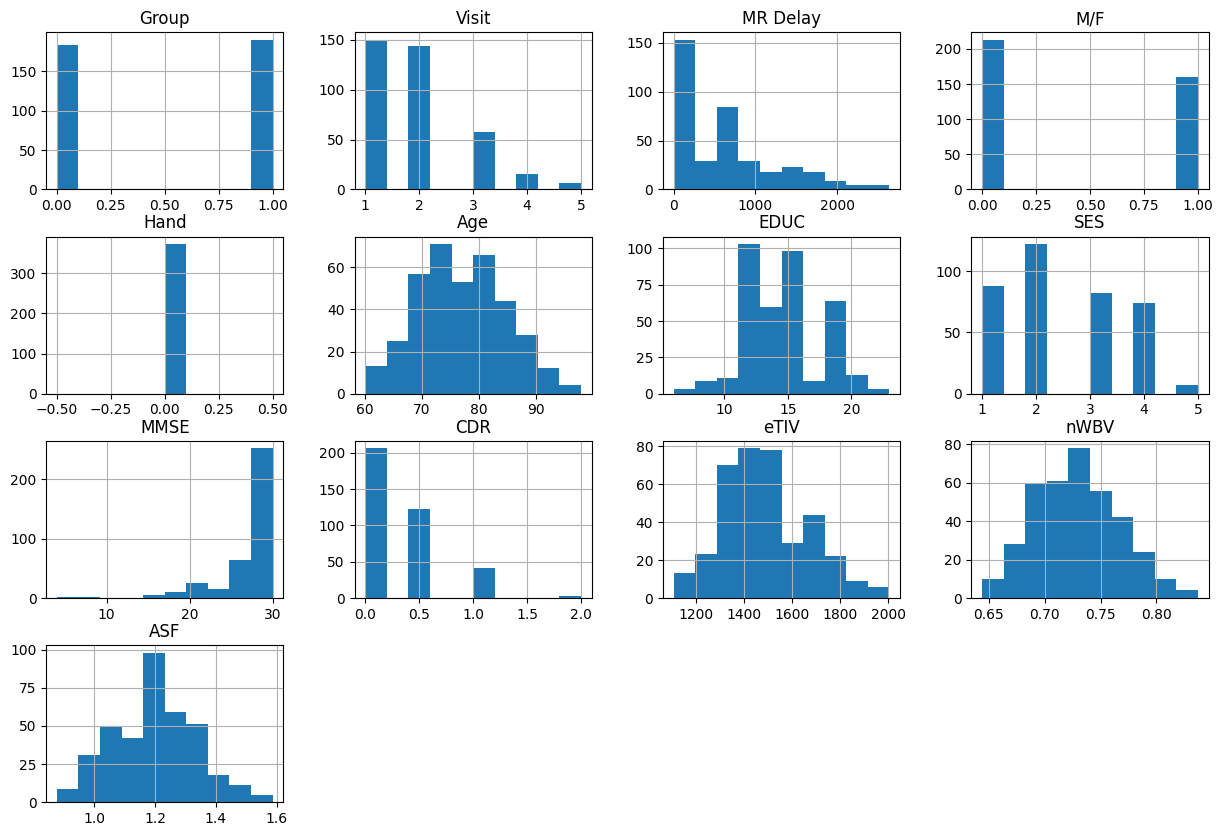

In [107]:
data.hist(figsize=(15, 10));

In [108]:
data['Hand'].unique()

array([0])

Looks like there are no left-handed people among the patients.

In [109]:
data = data.drop(['Hand'], axis = 1)

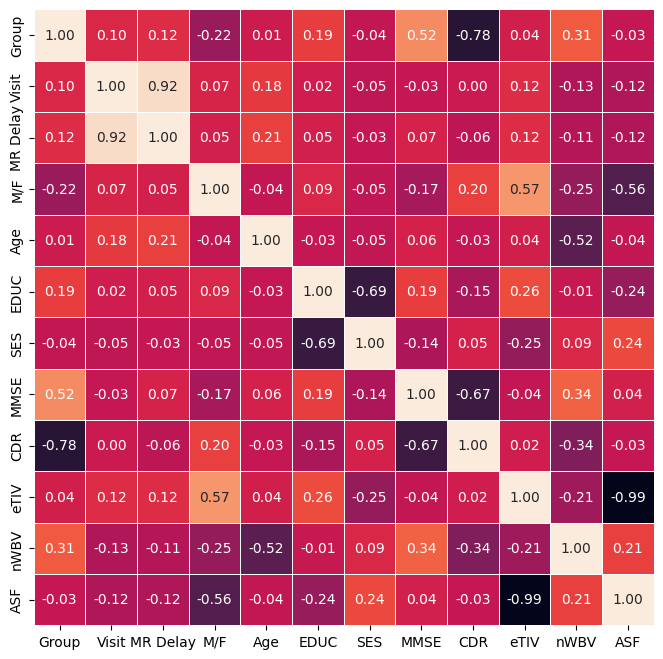

In [110]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

CDR is Clinical Dementia Rating.

In [111]:
data['CDR'].unique()

array([0. , 0.5, 1. , 2. ])

Most likely all patients who have CDR = 0 are not demented.

In [112]:
data[data['Group'] == 1]['CDR'].values

array([0. , 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.

In [113]:
data[data['Group'] == 0]['CDR'].values

array([0.5, 0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 0.5,
       0.5, 0. , 0. , 0.5, 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 1. , 0. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0. , 0. , 0.5, 0.5, 0.5, 1. , 1. , 1. , 0.5, 1. ,
       1. , 1. , 1. , 1. , 1. , 0.5, 1. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 1. , 0.5, 0.5, 1. , 0.5, 1. , 1. , 0.5, 0.5, 0.5,
       1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 1. , 2. , 1. , 1. , 0.5, 1. ,
       0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0. , 0.5, 0.5, 0.5,
       1. , 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 1. ,
       0.5, 0.5, 0. , 0.5, 1. , 2. , 0.5, 0.5, 0. , 0.5, 0.5, 0.5, 0.5,
       0.5, 0. , 0. , 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0. , 0.5, 0. , 0.5, 1. , 1. , 0.5, 1. , 1. , 1. , 0.5, 0.5, 0.5,
       1. , 0.5, 0.5, 1. , 2. , 1. , 1. , 0.5, 0.5, 0.5, 0.5, 0.5, 0. ,
       0. , 0.5, 0.5, 0.5, 0.5, 1. , 1. , 0.5, 0.5, 0.5, 1. , 0.

Even though three patients who don't have dementia still have positive CDR, and several patients with dementia have CDR = 0, this feature will be excluded from the analysis. The CDR testing is generally used to assess the stage and progression of Alzheimer disease, thus, the results of the test are part of the diagnosis.

In [114]:
data = data.drop(['CDR'], axis = 1)

eTIV and ASF are Estimated Total Intracranial Volume and ASF is Atlas Scaling Factor which is an atlas-based head size normalization technique to measure the standardized total intracranial volume. These anatomical parameters are both estimates of intracranial volume, so one of them (eTIV) will go. The rest of the features will be included in the analysis.

In [115]:
data = data.drop(['eTIV'], axis = 1)

In [116]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Group     373 non-null    int64  
 1   Visit     373 non-null    int64  
 2   MR Delay  373 non-null    int64  
 3   M/F       373 non-null    int64  
 4   Age       373 non-null    int64  
 5   EDUC      373 non-null    int64  
 6   SES       373 non-null    float64
 7   MMSE      373 non-null    float64
 8   nWBV      373 non-null    float64
 9   ASF       373 non-null    float64
dtypes: float64(4), int64(6)
memory usage: 29.3 KB


For binary classification, several gradient boosting models will be trained: Gradient Boosting from sklearn, XGBoost, CatBoost, LightGBM.

In [117]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Group'], axis=1), data['Group'], test_size=0.25, random_state=1,
stratify=data['Group'])

In [164]:
! pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [30]:
!pip install catboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [52]:
!pip install lightgbm

  Obtaining dependency information for lightgbm from https://files.pythonhosted.org/packages/b8/9d/1ce80cee7c5ef60f2fcc7e9fa97f29f7a8de3dc5a08922b3b2f1e9106481/lightgbm-4.1.0-py3-none-manylinux_2_28_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 3.6 MB/s eta 0:00:0000:0100:010m

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [84]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_f1 = f1_score(gb.predict(X_test), y_test)
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_f1 = f1_score(xgb.predict(X_test), y_test)
cb = CatBoostClassifier()
cb.fit(X_train, y_train)
cb_f1 = f1_score(cb.predict(X_test), y_test)
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
lgbm_f1 = f1_score(lgbm.predict(X_test), y_test)

Learning rate set to 0.005973
0:	learn: 0.6899244	total: 1.36ms	remaining: 1.36s
1:	learn: 0.6862327	total: 2.38ms	remaining: 1.19s
2:	learn: 0.6824395	total: 3.15ms	remaining: 1.05s
3:	learn: 0.6790425	total: 4ms	remaining: 997ms
4:	learn: 0.6748110	total: 4.96ms	remaining: 988ms
5:	learn: 0.6714851	total: 5.61ms	remaining: 930ms
6:	learn: 0.6681256	total: 6.21ms	remaining: 881ms
7:	learn: 0.6652265	total: 6.77ms	remaining: 840ms
8:	learn: 0.6621561	total: 7.83ms	remaining: 862ms
9:	learn: 0.6582364	total: 8.83ms	remaining: 874ms
10:	learn: 0.6555849	total: 9.28ms	remaining: 834ms
11:	learn: 0.6521973	total: 9.88ms	remaining: 813ms
12:	learn: 0.6487903	total: 10.5ms	remaining: 797ms
13:	learn: 0.6460708	total: 11.2ms	remaining: 790ms
14:	learn: 0.6434376	total: 12ms	remaining: 785ms
15:	learn: 0.6402308	total: 12.6ms	remaining: 773ms
16:	learn: 0.6370617	total: 13.1ms	remaining: 760ms
17:	learn: 0.6335048	total: 13.8ms	remaining: 750ms
18:	learn: 0.6303340	total: 14.5ms	remaining: 748

In [85]:
print('f1 score of models before tuning')
print(f'GradientBoosting: {gb_f1:.4f}')
print(f'XGboost: {xgb_f1:.4f}')
print(f'CatBoost: {cb_f1:.4f}')
print(f'LightGBM: {lgbm_f1:.4f}')

f1 score of models before tuning
GradientBoosting: 0.8571
XGboost: 0.8800
CatBoost: 0.8738
LightGBM: 0.8269


XGBoost is the best performing model so far.

In [33]:
parameters = {'n_estimators': [50, 300, 500], 'max_features' : [None, 3], 'subsample' : [0, 0.5, 1], 'max_depth' : [3, 5, 10]}
model = GradientBoostingClassifier()
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
gb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'max_depth': 10, 'max_features': None, 'n_estimators': 50, 'subsample': 0.5}


In [34]:
parameters = {'random_state' : [None, 1], 'warm_start' : [True, False], 'loss' : ['log_loss', 'exponential']}
model = GradientBoostingClassifier(max_depth=10, max_features=None, n_estimators=50, subsample=0.5)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
gb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'loss': 'log_loss', 'random_state': 1, 'warm_start': True}


In [35]:
parameters = {'n_estimators': [10, 300, 500], 'max_features' : [None, 3], 'subsample' : [0.05, 0.5, 1], 
              'max_depth' : [1, 5, 10]}
model = XGBClassifier()
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
xgb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'max_depth': 10, 'max_features': None, 'n_estimators': 500, 'subsample': 1}


In [36]:
parameters = {'min_child_weight' : [0, 1, 5], 'learning_rate' : [0.01, 0.05, 0.1],
              'min_sample_leaf' : [1, 10, 50], 'random_state' : [None, 1]}
model = XGBClassifier(max_depth=10, max_features=None, n_estimators=500, subsample=1)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
xgb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'learning_rate': 0.05, 'min_child_weight': 0, 'min_sample_leaf': 1, 'random_state': None}


In [37]:
parameters = {'iterations': [10, 300, 500], 'depth' : [1, 10, 50]}
model = CatBoostClassifier()
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
cb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

Learning rate set to 0.370391
0:	learn: 0.5999483	total: 266us	remaining: 2.4ms
1:	learn: 0.5694982	total: 401us	remaining: 1.61ms
2:	learn: 0.5307479	total: 464us	remaining: 1.08ms
3:	learn: 0.5095044	total: 782us	remaining: 1.17ms
4:	learn: 0.4963782	total: 861us	remaining: 861us
5:	learn: 0.4915439	total: 1.06ms	remaining: 708us
6:	learn: 0.4896533	total: 1.18ms	remaining: 506us
7:	learn: 0.4879266	total: 1.31ms	remaining: 326us
8:	learn: 0.4827426	total: 1.36ms	remaining: 151us
9:	learn: 0.4755570	total: 1.5ms	remaining: 0us
Learning rate set to 0.370391
0:	learn: 0.6058367	total: 280us	remaining: 2.53ms
1:	learn: 0.5494527	total: 539us	remaining: 2.16ms
2:	learn: 0.5224303	total: 686us	remaining: 1.6ms
3:	learn: 0.4939108	total: 754us	remaining: 1.13ms
4:	learn: 0.4797929	total: 3.85ms	remaining: 3.85ms
5:	learn: 0.4652124	total: 4.35ms	remaining: 2.9ms
6:	learn: 0.4573806	total: 4.48ms	remaining: 1.92ms
7:	learn: 0.4550308	total: 4.64ms	remaining: 1.16ms
8:	learn: 0.4500745	total

In [38]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'depth': 10, 'iterations': 500}


In [39]:
parameters = {'learning_rate' : [0.1, 0.3, 0.5], 'subsample' : [0.1, 0.5, 1]}
model = CatBoostClassifier(depth=10, iterations=500)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
cb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

0:	learn: 0.6425431	total: 13.9ms	remaining: 6.95s
1:	learn: 0.6179869	total: 15.2ms	remaining: 3.79s
2:	learn: 0.5789375	total: 24.5ms	remaining: 4.05s
3:	learn: 0.5584971	total: 26.5ms	remaining: 3.28s
4:	learn: 0.5214509	total: 42.2ms	remaining: 4.18s
5:	learn: 0.4895573	total: 55.2ms	remaining: 4.54s
6:	learn: 0.4695547	total: 62.4ms	remaining: 4.39s
7:	learn: 0.4402263	total: 70.1ms	remaining: 4.31s
8:	learn: 0.4222833	total: 78.2ms	remaining: 4.27s
9:	learn: 0.4006959	total: 83.4ms	remaining: 4.09s
10:	learn: 0.3827726	total: 89.7ms	remaining: 3.99s
11:	learn: 0.3713558	total: 94.8ms	remaining: 3.85s
12:	learn: 0.3513033	total: 100ms	remaining: 3.76s
13:	learn: 0.3343070	total: 105ms	remaining: 3.64s
14:	learn: 0.3267669	total: 108ms	remaining: 3.49s
15:	learn: 0.3157175	total: 113ms	remaining: 3.4s
16:	learn: 0.3035721	total: 117ms	remaining: 3.32s
17:	learn: 0.2946075	total: 122ms	remaining: 3.25s
18:	learn: 0.2827251	total: 127ms	remaining: 3.22s
19:	learn: 0.2722653	total: 13

In [40]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'learning_rate': 0.1, 'subsample': 0.5}


In [41]:
parameters = {'colsample_bylevel': [0.1, 0.5, 1], 'min_data_in_leaf' : [1, 50, 100]}
model = CatBoostClassifier(depth=10, iterations=500, learning_rate=0.1, subsample=0.5)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
cb_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

0:	learn: 0.6868861	total: 16.4ms	remaining: 8.21s
1:	learn: 0.6868464	total: 17.3ms	remaining: 4.31s
2:	learn: 0.6798310	total: 18ms	remaining: 2.98s
3:	learn: 0.6504824	total: 21ms	remaining: 2.6s
4:	learn: 0.6021157	total: 21.8ms	remaining: 2.15s
5:	learn: 0.5919681	total: 22.5ms	remaining: 1.85s
6:	learn: 0.5666355	total: 23ms	remaining: 1.62s
7:	learn: 0.5354846	total: 30.2ms	remaining: 1.86s
8:	learn: 0.5353336	total: 30.6ms	remaining: 1.67s
9:	learn: 0.5352112	total: 31ms	remaining: 1.52s
10:	learn: 0.5351127	total: 31.3ms	remaining: 1.39s
11:	learn: 0.5350333	total: 31.5ms	remaining: 1.28s
12:	learn: 0.5140353	total: 32.3ms	remaining: 1.21s
13:	learn: 0.5117452	total: 32.6ms	remaining: 1.13s
14:	learn: 0.5116607	total: 33ms	remaining: 1.07s
15:	learn: 0.5105760	total: 33.4ms	remaining: 1.01s
16:	learn: 0.5096347	total: 33.7ms	remaining: 957ms
17:	learn: 0.5095907	total: 34.1ms	remaining: 912ms
18:	learn: 0.4940617	total: 34.6ms	remaining: 876ms
19:	learn: 0.4902055	total: 35.6m

In [119]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'colsample_bylevel': 1, 'min_data_in_leaf': 1}


In [121]:
parameters = {'num_iterations': [10, 300, 500], 'max_depth' : [1, 10, 50], 'subsample' : [0.1, 0.5, 1]}
model = LGBMClassifier(force_col_wise=True)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
lgbm_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 114, number of negative: 109
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 223, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511211 -> initscore=0.044851
[LightGBM] [Info] Start training from score 0.044851
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 114, number of negative: 109
[LightGBM] [Info] Total Bins 247
[LightGBM] [Info] Number of data points in the train set: 223, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511211 -> initscore=0.044851
[LightGBM] [Info] Start training from score 0.044851
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113, number of negative: 110
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info

In [122]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'max_depth': 1, 'num_iterations': 300, 'subsample': 0.1}


In [126]:
parameters = {'num_leaves': [10, 300, 500], 'min_data_in_leaf' : [1, 50, 100], 'learning_rate' : [0.01, 0.5, 1]}
model = LGBMClassifier(force_col_wise=True, max_depth=1, num_iterations=300, subsample=0.1)
adj_model = GridSearchCV(model, parameters, scoring = 'f1')
adj_model.fit(X_train, y_train)
lgbm_adj = adj_model.predict(X_test)
print('Best parameters: ', adj_model.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 114, number of negative: 109
[LightGBM] [Info] Total Bins 245
[LightGBM] [Info] Number of data points in the train set: 223, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511211 -> initscore=0.044851
[LightGBM] [Info] Start training from score 0.044851
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf 

In [127]:
print('Best parameters: ', adj_model.best_params_)

Best parameters:  {'learning_rate': 0.01, 'min_data_in_leaf': 1, 'num_leaves': 50}


In [128]:
print('f1 score of models after tuning:')
print(f'GB: {f1_score(gb_adj, y_test):.4f}')
print(f'XGBoost: {f1_score(xgb_adj, y_test):.4f}')
print(f'CatBoost: {f1_score(cb_adj, y_test):.4f}')
print(f'LGBM: {f1_score(lgbm_adj, y_test):.4f}')

f1 score of models after tuning:
GB: 0.8654
XGBoost: 0.8627
CatBoost: 0.8571
LGBM: 0.8000


Now the best performing model is GB.